Modules:

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

To align with the methodology of Mehra and Prescott (1985), The monthly return of the S&P 500 index is annualized and used as the market return. The annual average return of the 3-month Treasury bond yield is used as the risk-free rate. The monthly Personal Consumption Expenditures (PCE) is annualized and used as the annual growth rate of consumption, while the monthly Consumer Price Index (CPI) is annualized and used as the annual inflation rate. The data is obtained from the Federal Reserve Bank of St. Louis (FRED) database and Market Insights.
<br>
<br>
The data is cleaned and prepared for the analysis as follows: 


In [50]:
##### Import data ##### 

### Monthly SP500 ###
# Read Excel file for SP500
SP500 = pd.read_excel('SP500.xlsx', index_col=0)

# Convert index to datetime 
SP500.index = pd.to_datetime(SP500.index)

### Daily DGS3MO ###
DDGS3MO =  pd.read_csv('DGS3MO.csv', index_col=0)

# Convert index to datetime 
DDGS3MO.index = pd.to_datetime(DDGS3MO.index)

# Rename column 
DDGS3MO.columns = ['DDGS3MO']

### Monthly DGS3MO ###
MDGS3M0 = DDGS3MO.resample('M').last()

# Change index to first of month
MDGS3M0.index = MDGS3M0.index.to_period('M').to_timestamp()

# Rename column 
MDGS3M0.columns = ['MDGS3MO']

### Monthly PCE ###
PCE =  pd.read_csv('PCE.csv', index_col=0)

# Convert index to datetime 
PCE.index = pd.to_datetime(PCE.index)

### Monthly PCEPI ###
PCEPI =  pd.read_csv('PCEPI.csv', index_col=0)

# Convert index to datetime 
PCEPI.index = pd.to_datetime(PCEPI.index)

##### Convert data to annual changes #####

### Roll over T-Bills each quarter ###
# Return from holding a 3M T-Bill to maturity
QDGS3M0 = np.log(1+MDGS3M0/400)

# Simulate annual return from rolling over every 3 months
ADGS3M0 = (
    QDGS3M0
    + QDGS3M0.shift(3)
    + QDGS3M0.shift(6)
    + QDGS3M0.shift(9)
)

# Shift to find realized return
ADGS3M0 = ADGS3M0.shift(3)

# Rename column 
ADGS3M0.columns = ['ADGS3M0']

##### Join DataFrames #####
# Join on the dates of ADGS3M0
df = ADGS3M0.join([SP500, PCE, PCEPI], how='left')

##### Change dates of the DataFrame #####
# Define start and end dates 
start_date, end_date = '1984-12-01', '2024-12-01'

# Slice the DataFrame between the two dates
df = df.loc[start_date:end_date]

##### Dataframe for Mehra and Prescott #####
# Filter for December
df_MP = df.copy()

# Calculate log return and changes for SP500, PCE, PCEPI and EP
df_MP["RET_SP500"] = np.log(df_MP["SP500"] / df_MP["SP500"].shift(1))
df_MP["CHG_PCE"] = np.log(df_MP["PCE"] / df_MP["PCE"].shift(1))
df_MP["CHG_PCEPI"] = np.log(df_MP["PCEPI"] / df_MP["PCEPI"].shift(1))
df_MP["EP"] = df_MP["RET_SP500"] - df_MP["ADGS3M0"]

# Real return and changes
df_MP["R_ADGS3M0"] = df_MP["ADGS3M0"] - df_MP["CHG_PCEPI"]
df_MP["R_RET_SP500"] = df_MP["RET_SP500"] - df_MP["CHG_PCEPI"]
df_MP["R_CHG_PCE"] = df_MP["CHG_PCE"] - df_MP["CHG_PCEPI"]
df_MP["R_EP"]  = df_MP["R_RET_SP500"] - df_MP["R_ADGS3M0"]

# Explore Data (Remember that ADGS3MO counts 1 more than SP500 for EP)
df_MP.describe()

C:\Users\jonas\AppData\Local\Temp\ipykernel_11956\2016649617.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  MDGS3M0 = DDGS3MO.resample('M').last()


,ADGS3M0,SP500,PCE,PCEPI,RET_SP500,CHG_PCE,CHG_PCEPI,EP,R_ADGS3M0,R_RET_SP500,R_CHG_PCE,R_EP
count,481.000000,481.000000,481.000000,481.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.033450,1516.782141,8940.295218,82.254451,0.007417,0.004307,0.001944,-0.025895,0.031368,0.005474,0.002363,-0.025895
std,0.026625,1269.510917,4625.141469,19.446598,0.044372,0.009488,0.001987,0.051032,0.026302,0.044378,0.009019,0.051032
min,0.000175,167.200000,2582.600000,49.081000,-0.245295,-0.121178,-0.011872,-0.302557,-0.008323,-0.248464,-0.116996,-0.302557
25%,0.006469,475.500000,4841.600000,66.991000,-0.017583,0.002108,0.000932,-0.054941,0.004591,-0.018835,0.000220,-0.054941
50%,0.032912,1191.300000,8497.700000,80.801000,0.012102,0.004134,0.001845,-0.020850,0.030689,0.010179,0.002316,-0.020850
75%,0.052824,1972.290000,12083.900000,97.291000,0.035356,0.006801,0.003033,0.006397,0.051725,0.033299,0.004772,0.006397
max,0.099646,6032.380000,20408.100000,124.769000,0.123729,0.079874,0.009604,0.101299,0.093922,0.123602,0.078940,0.101299


Plots for data exploration:

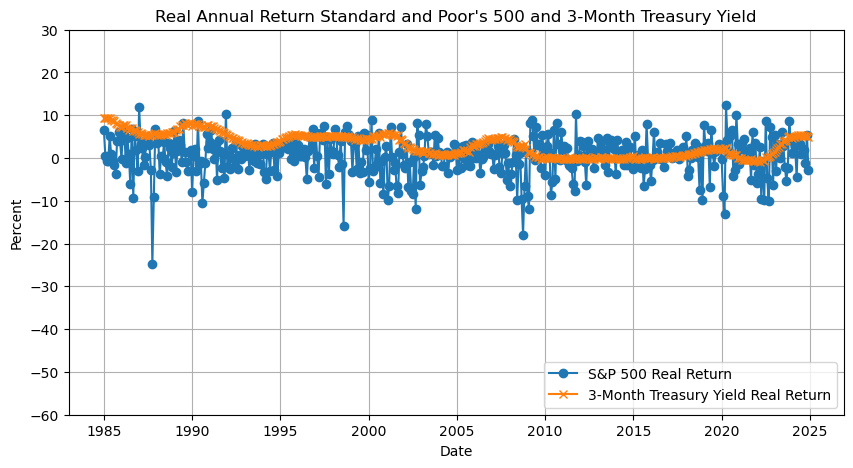

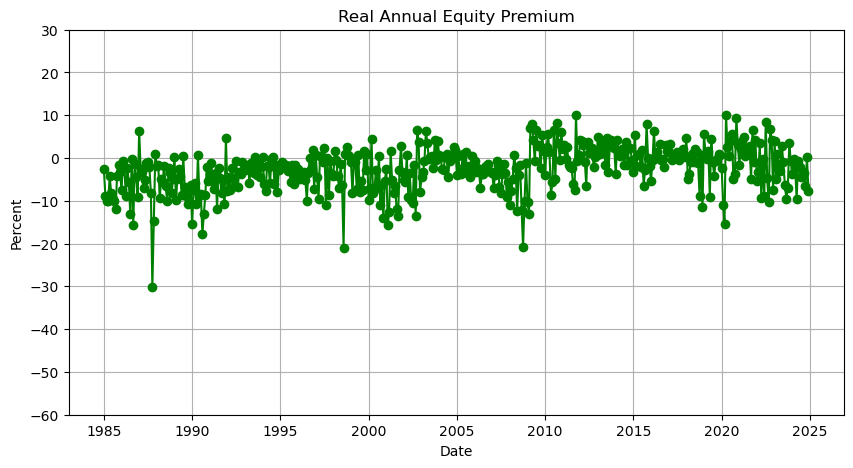

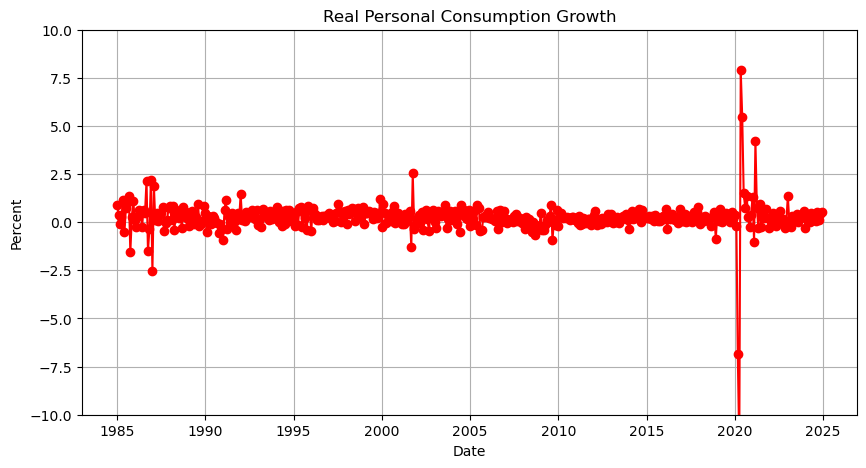

In [51]:
# Real Market Return and Yield
plt.figure(figsize=(10, 5))
plt.plot(df_MP.index, df_MP['R_RET_SP500']*100, marker='o', label="S&P 500 Real Return")
plt.plot(df_MP.index, df_MP['R_ADGS3M0']*100, marker='x', label="3-Month Treasury Yield Real Return")
plt.xlabel('Date')
plt.ylabel('Percent')
plt.title('Real Annual Return Standard and Poor\'s 500 and 3-Month Treasury Yield')
plt.legend(loc="lower right")
plt.ylim(-60, 30)
plt.grid()
plt.show()

# Real Equity Premium
plt.figure(figsize=(10, 5))
plt.plot(df_MP.index, df_MP['R_EP']*100, marker='o', color="green")
plt.xlabel('Date')
plt.ylabel('Percent')
plt.title('Real Annual Equity Premium')
plt.ylim(-60, 30)
plt.grid()
plt.show()

# Real Growth Rate of Consumption
plt.figure(figsize=(10, 5))
plt.plot(df_MP.index, df_MP['R_CHG_PCE']*100, marker='o', color="red")
plt.xlabel('Date')
plt.ylabel('Percent')
plt.title('Real Personal Consumption Growth')
plt.ylim(-10, 10)
plt.grid()
plt.show()

The model of Mehra and Prescott:

In [52]:
### Set the variables of the model ###

# Mean real consumption growth rate
mu_x = df_MP["R_CHG_PCE"].mean()

# Standard deviation of real consumption growth rate
sigma_x = df_MP["R_CHG_PCE"].std()

### Set beta and alpha ###
alpha = 10
beta = 0.99

### Expected real return on equity and risk-free asset ###
# Real risk-free return
E_Rf = -np.log(beta)+alpha*mu_x-1/2*(alpha**2)*(sigma_x**2)

# Real equity return
E_Re = E_Rf+alpha*(sigma_x**2)

# Equity risk-premium
E_Rp = E_Re-E_Rf

# Print results
print(f"Real expected return on equity is {np.round(E_Re,5)*100}%, real expected return on risk-free asset {np.round(E_Rf,5)*100}% and equity risk-premium is given by {np.round(E_Rp,5)*100}%")

Real expected return on equity is 3.042%, real expected return on risk-free asset 2.9610000000000003% and equity risk-premium is given by 0.08099999999999999%


In [53]:
### Prescott and Mehra (2003) ###

# Mean real consumption growth rate
mu_x_mp = np.log(1.018)

# Standard deviation of real consumption growth rate
sigma_x_mp = 0.036

### Set beta and alpha ###
alpha_mp = 10
beta_mp = 0.99

### Expected real return on equity and risk-free asset ###

# Real risk-free return
E_Rf_mp = -np.log(beta_mp)+alpha_mp*mu_x_mp-1/2*(alpha_mp**2)*(sigma_x_mp**2)

# Real equity return
E_Re_mp = E_Rf_mp+alpha_mp*(sigma_x_mp**2)

# Equity risk-premium
E_Rp_mp = E_Re_mp-E_Rf_mp

# Print results
print(f"Real expected return on equity is {np.round(E_Re_mp*100,5)}%, real expected return on risk-free asset {np.round(E_Rf_mp*100,5)}% and equity risk-premium is given by {np.round(E_Rp_mp*100,5)}%.")

Real expected return on equity is 13.66095%, real expected return on risk-free asset 12.36495% and equity risk-premium is given by 1.296%.


In [54]:
### Magnitude of equity premium puzzle ###
magnitude = E_Rp_mp/E_Rp

print(f"As the model is linear in its parameters one can easily conclude that the equity premium puzzle has increased by a magnitude of {np.round(magnitude,5)}.")

As the model is linear in its parameters one can easily conclude that the equity premium puzzle has increased by a magnitude of 15.9339.


Myopic Loss Aversion (MLA) model:

In [754]:
# Data
x = df_MP["RET_SP500"]

# Parameters
alpha = 0.88
beta = 0.88
lam = 2.25
gamma_gain = 0.61
gamma_loss = 0.68

# Define value function
def value_function(x, alpha, beta, lam):
    if x >= 0:
        return x**alpha
    else:
        return -lam * ((-x)**beta)
    
# Define weighting function
def weighting_function(p, gamma):
    return (p**gamma)/((p**gamma + (1 - p)**gamma)**(1/gamma))

def cpt_utility(x):
    # Sort values ascending
    x = np.sort(x)

    # Find lenght of data
    n = len(x)

    # Seperate into gains and losses
    x_gain = x[(x >= 0)]
    x_loss = x[(x < 0)]

    ### Gains ###
    if len(x_gain) > 0:
        # CDF for gains
        ECDF_gain = ECDF(x_gain)

        # Unique values for the gains
        unique_gain = np.unique(x_gain)

        # CCDF = 1 - ECDF(x) + P(X = x)
        unique_probs_gain = (1 - ECDF_gain(unique_gain) + np.array([np.sum(x_gain == x) / len(x_gain) for x in unique_gain])) * (len(x_gain)/n)

        ### Prospect utility for gains ###
        # Add zero to the end of probabilities
        unique_probs_gain_with_zero = np.append(unique_probs_gain, 0) 

        # Initialize utility
        utility_gain = 0

        for i in range(len(unique_gain)):
            utility_gain += value_function(unique_gain[i], alpha, beta, lam) \
                * (weighting_function(unique_probs_gain_with_zero[i], gamma=gamma_gain) \
                    - weighting_function(unique_probs_gain_with_zero[i+1], gamma=gamma_gain))

    else:
        utility_gain = 0

    if len(x_loss) > 0: 
    ### Losses ###
    # CDF for losses
        ECDF_loss = ECDF(x_loss)

        # Unique valus for the losses
        unique_loss = np.unique(x_loss)

        # Get ECDF probabilities at the unique values
        unique_probs_loss = ECDF_loss(unique_loss) * (len(x_loss)/n)

        ### Prospect utility for losses ###
        # Sort descending and add zero at the end of probabilities
        unique_loss_desc = unique_loss[::-1]
        unique_probs_loss_desc_with_zero = np.append(unique_probs_loss[::-1], 0)

        # Initialize utility
        utility_loss = 0

        for i in range(len(unique_loss_desc)):
            utility_loss += value_function(unique_loss_desc[i], alpha, beta, lam) \
                * (weighting_function(unique_probs_loss_desc_with_zero[i], gamma=gamma_loss) \
                    - weighting_function(unique_probs_loss_desc_with_zero[i+1], gamma=gamma_loss))    

    else:
        utility_loss = 0
        
    ### Sum of utilities ###
    utility = utility_loss + utility_gain

    return utility

# Define block bootstrap function
def block_boostrap(x, block_lenght=12, n_samples=100000):
    # Data lenght
    n = len(x)

    # Save returns in list
    ret = []

    for i in range(n_samples):
        # Last possible start
        last_start = n-block_lenght
        
        # Find start
        start = np.random.randint(0,last_start+1) # +1 due to the way python works with counting

        # Take block
        block = x[start:start+block_lenght]

        # Find return
        block_ret = np.exp(np.sum(block))-1

        # Append returns to list
        ret.append(block_ret)
    
    return np.array(ret)

### Loop for determining prospect utility ###
# Save results
months =[]
utility = []

for i in range(0, 19):
    # Block bootstrap for block lenght i
    data = block_boostrap(x, block_lenght=i, n_samples=1000)
    
    # CPT utility
    cpt = cpt_utility(data)
    
    # Append results
    months.append(i)
    utility.append(cpt)

months, utility


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [0.0,
  -0.03318539714033671,
  -0.02153120164657494,
  -0.026602278220345263,
  -0.01681624646660533,
  -0.008556716096910083,
  -0.010519579326124975,
  -0.017453384982823922,
  0.0012268434737473521,
  0.0013056168540724888,
  -0.005491166585895907,
  0.007138309838146284,
  0.01754308258906906,
  0.030627695473072813,
  0.0233881021342775,
  0.04742987401770929,
  0.05032916461304204,
  0.057722764097421525,
  0.04168794221500574])

In [753]:
res_stock = pd.DataFrame([months, utility])
res_stock

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.00000,15.000000,16.000000,17.000000,18.000000
1,0.0,-0.029637,-0.033319,-0.030184,-0.022931,-0.017999,-0.013727,-0.009254,-0.007402,-0.003008,0.006914,0.012919,0.014017,0.023613,0.02521,0.034536,0.041561,0.047636,0.055496
